In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import IPython

$y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon$ where $ \epsilon \sim \mathcal{N}(0, 0.1^2)$.


In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

In [3]:
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
#np.power表示features ** i
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

In [4]:

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
# 生成真实数据，前100个为训练数据，后100个为测试数据
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.8684],
         [-0.3633]]),
 tensor([[ 1.0000e+00, -1.8684e+00,  1.7454e+00, -1.0870e+00,  5.0772e-01,
          -1.8972e-01,  5.9078e-02, -1.5768e-02,  3.6826e-03, -7.6449e-04,
           1.4283e-04, -2.4260e-05,  3.7772e-06, -5.4286e-07,  7.2447e-08,
          -9.0238e-09,  1.0537e-09, -1.1581e-10,  1.2021e-11, -1.1820e-12],
         [ 1.0000e+00, -3.6331e-01,  6.5996e-02, -7.9924e-03,  7.2592e-04,
          -5.2747e-05,  3.1939e-06, -1.6577e-07,  7.5280e-09, -3.0389e-10,
           1.1041e-11, -3.6465e-13,  1.1040e-14, -3.0853e-16,  8.0065e-18,
          -1.9392e-19,  4.4034e-21, -9.4105e-23,  1.8994e-24, -3.6319e-26]]),
 tensor([-9.0723,  4.3190]))

In [6]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
# 转换为 Tensor， 并打乱顺序
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    '''*data_arrays表示解包， 将元组中的变量单独拿出来'''
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [8]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和,训练准确度总和,样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
    # 返回训练损失和训练准确度
    return metric[0] / metric[2], metric[1] / metric[2]

In [9]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 正常数据

weight: [[ 5.0119023  1.1902622 -3.4066942  5.622057 ]]


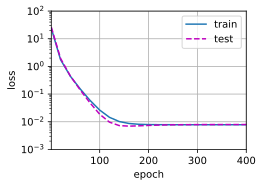

In [10]:

# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## 模型容量较小，数据欠拟合

weight: [[3.6304286 3.9516447]]


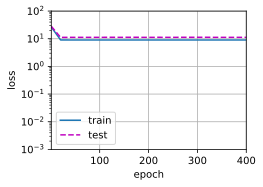

In [11]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## 过拟合

weight: [[ 4.988348    1.3076819  -3.261322    5.058639   -0.37611833  1.4230272
  -0.01576982  0.19099368 -0.1881185  -0.16264337  0.16058627 -0.08120369
   0.02474231  0.12561087  0.09936985 -0.17750363 -0.08244717  0.12019057
   0.15816641  0.16922832]]


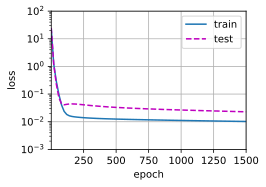

In [12]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)